In [5]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Verifică GPU-urile disponibile
gpus = tf.config.list_physical_devices('GPU')
print(f"Available GPUs: {gpus}")

# # Permite alocarea progresivă a memoriei pe GPU-uri
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
#tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
# Creează strategia pentru distribuire pe GPU-uri
strategy = tf.distribute.MirroredStrategy()

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


2025-01-09 14:14:28.092038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43611 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6
2025-01-09 14:14:28.094499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43611 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:c1:00.0, compute capability: 8.6
2025-01-09 14:14:28.096777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43611 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:e1:00.0, compute capability: 8.6


In [3]:
# Încarcă datele
df = pd.read_csv("../datasets/fake_or_real_news.csv")


In [4]:
df.head()
print(df["text"].isnull().sum())

0


In [6]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Text(0, 0.5, 'Number of texts')

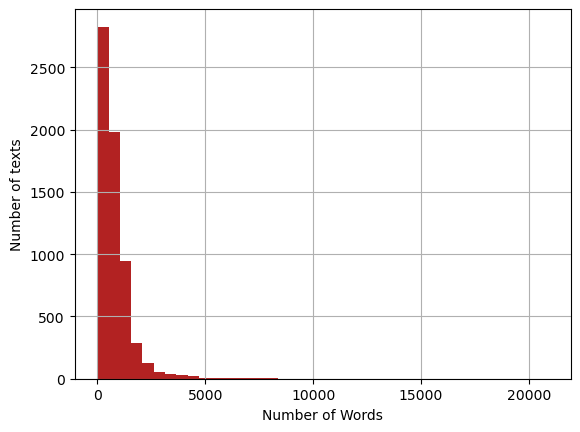

In [7]:
seq_len = [len(text.split()) for text in df["text"]]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [8]:
label_mapping = {"REAL": 0, "FAKE": 1}
df['label'] = df['label'].map(label_mapping)

# Extrage textele și labelurile
texts = df['text'].tolist()
labels = df['label'].tolist()

In [9]:
model_path = "../saved_models/saved_bert_model"
tokenizer_path = "../saved_models/saved_bert_tokenizer"

model = TFBertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

# Activează alocarea progresivă a memoriei GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Funcția de predicție pentru un set de texte
def predict_proba(texts):
    tokens = tokenizer(
        texts,
        max_length=128,
        padding=True,
        truncation=True,
        return_tensors="tf"
    )
    # Obține logits (output brut) de la model
    logits = model(tokens).logits

    # Convertim logits în probabilități pentru ambele clase
    probabilities = tf.sigmoid(logits)  # Probabilitatea pentru FAKE (clasa 1)
    probabilities = tf.concat([1 - probabilities, probabilities], axis=1)  # Probabilități pentru [REAL, FAKE]
    return probabilities.numpy()

# Funcția pentru procesarea în batch-uri
from tqdm import tqdm  # Pentru progres vizual

def predict_in_batches(texts, batch_size=32):
    predictions = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        batch_predictions = predict_proba(batch_texts)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Obține predicțiile folosind batch-uri
batch_size = 32  # Poți ajusta această valoare în funcție de memoria GPU
predictions = predict_in_batches(texts, batch_size=batch_size)

# Obține etichetele prezise
predicted_labels = np.argmax(predictions, axis=1)

# Creează raportul de clasificare
from sklearn.metrics import classification_report
print(classification_report(labels, predicted_labels, target_names=["REAL", "FAKE"]))

Some layers from the model checkpoint at ../saved_models/saved_bert_model were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../saved_models/saved_bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
100%|██████████| 198/198 [01:49<00:00,  1.81i

              precision    recall  f1-score   support

        REAL       0.99      0.99      0.99      3171
        FAKE       0.99      0.99      0.99      3164

    accuracy                           0.99      6335
   macro avg       0.99      0.99      0.99      6335
weighted avg       0.99      0.99      0.99      6335



In [10]:
correct_indices = [i for i, (true, pred) in enumerate(zip(labels, predicted_labels)) if true == pred]
incorrect_indices = [i for i, (true, pred) in enumerate(zip(labels, predicted_labels)) if true != pred]

correct_texts = [texts[i] for i in correct_indices]
incorrect_texts = [texts[i] for i in incorrect_indices]
incorrect_labels = [labels[i] for i in incorrect_indices]

print(f"Numărul de predicții corecte: {len(correct_texts)}")
print(f"Numărul de predicții greșite: {len(incorrect_texts)}")

Numărul de predicții corecte: 6288
Numărul de predicții greșite: 47


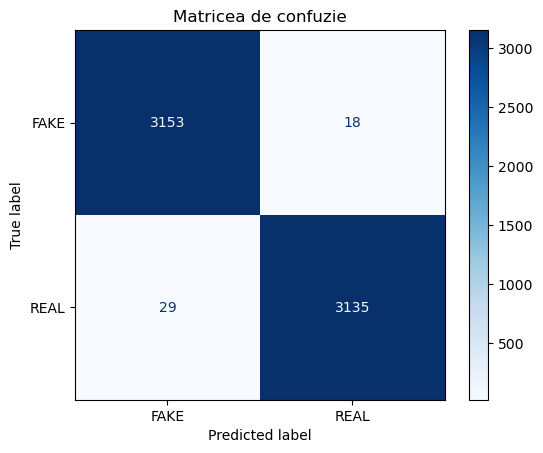

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Creează matricea de confuzie
cm = confusion_matrix(labels, predicted_labels)

# Afișează matricea de confuzie
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matricea de confuzie")
plt.show()


In [12]:
# Afișează predicțiile incorecte cu confidence score
for i in incorrect_indices:
    text = texts[i]
    true_label = labels[i]
    predicted_label = predicted_labels[i]
    confidence = predictions[i][predicted_label]  # Probabilitatea pentru clasa prezisă
    print(f"Text: {text}")
    print(f"Etichetă adevărată: {true_label}")
    print(f"Etichetă prezisă: {predicted_label}")
    print(f"Confidence: {confidence:.2f}")
    print("-" * 80)


Text: Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. 
In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. 
The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. 
But that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. 
The FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. 
The FBI’s leadership is being warned that the entir

# SHAP

In [14]:
import shap
import numpy as np

# Creează un masker bazat pe tokenizer
masker = shap.maskers.Text(tokenizer)

# Creează un explainer SHAP pentru modelul BERT
explainer = shap.Explainer(lambda x: predict_proba(list(x)), masker)

# Listă pentru a stoca explicațiile
shap_results = []

# Selectează câteva exemple greșite pentru analiza SHAP
texts_to_explain = incorrect_texts[:5]  # Primele 5 exemple greșite

# Iterează prin textele selectate și generează explicații
for i, text in enumerate(texts_to_explain):
    print(f"Procesare exemplu {i + 1}...")
    
    # Generează explicația SHAP pentru textul curent
    shap_values = explainer([text])

    # Extrage contribuțiile pentru fiecare cuvânt
    tokens = tokenizer.tokenize(text)  # Tokenizează textul
    contributions = [
        (token, importance) 
        for token, importance in zip(tokens, shap_values.values[0])
    ]

    # Stochează informațiile într-un dicționar
    shap_results.append({
        "text": text,
        "true_label": incorrect_labels[i],
        "predicted_label": predicted_labels[incorrect_indices[i]],
        "contributions": contributions
    })


# Transformă rezultatele într-un DataFrame pentru analiză ulterioară
import pandas as pd
shap_df = pd.DataFrame(shap_results)

# Salvează rezultatele într-un fișier CSV
shap_df.to_csv("shap_explanations.csv", index=False)
print("Rezultatele SHAP au fost salvate în 'shap_explanations.csv'.")


Procesare exemplu 1...


PartitionExplainer explainer: 2it [02:46, 166.92s/it]              


Procesare exemplu 2...


PartitionExplainer explainer: 2it [01:00, 60.20s/it]               


Procesare exemplu 3...


PartitionExplainer explainer: 2it [01:00, 60.87s/it]               


Procesare exemplu 4...


PartitionExplainer explainer: 2it [03:32, 213.00s/it]              


Procesare exemplu 5...


PartitionExplainer explainer: 2it [06:17, 377.56s/it]              


Rezultatele SHAP au fost salvate în 'shap_explanations.csv'.


# Lime


In [13]:
from lime.lime_text import LimeTextExplainer

# Creează explainer-ul LIME
explainer = LimeTextExplainer(class_names=["REAL", "FAKE"])

# Listă pentru a stoca explicațiile
lime_results = []

# Explică primele 5 predicții greșite și stochează informațiile
for i, text in enumerate(incorrect_texts):  # Poți crește numărul dacă dorești
    print(f"Procesare exemplu greșit {i + 1}...")
    explanation = explainer.explain_instance(
        text,
        predict_proba,
        num_features=10,  # Numărul de caracteristici explicate
        num_samples=1000  # Numărul de eșantioane generate
    )
    
    # Extrage contribuțiile fiecărui cuvânt (caracteristici)
    contributions = explanation.as_list()  # [(word, importance), ...]
    
    # Stochează informațiile într-un dicționar
    lime_results.append({
        "text": text,
        "true_label": incorrect_labels[i],
        "predicted_label": predicted_labels[incorrect_indices[i]],
        "contributions": contributions
    })

# Transformă rezultatele într-un DataFrame pentru analiză ulterioară
import pandas as pd
lime_df = pd.DataFrame(lime_results)

# Salvează rezultatele într-un fișier CSV pentru analiză ulterioară
lime_df.to_csv("lime_explanations.csv", index=False)
print("Rezultatele LIME au fost salvate în 'lime_explanations.csv'.")

Procesare exemplu greșit 1...
Procesare exemplu greșit 2...
Procesare exemplu greșit 3...
Procesare exemplu greșit 4...
Procesare exemplu greșit 5...
Procesare exemplu greșit 6...
Procesare exemplu greșit 7...
Procesare exemplu greșit 8...
Procesare exemplu greșit 9...
Procesare exemplu greșit 10...
Procesare exemplu greșit 11...
Procesare exemplu greșit 12...
Procesare exemplu greșit 13...
Procesare exemplu greșit 14...
Procesare exemplu greșit 15...
Procesare exemplu greșit 16...
Procesare exemplu greșit 17...
Procesare exemplu greșit 18...
Procesare exemplu greșit 19...
Procesare exemplu greșit 20...
Procesare exemplu greșit 21...
Procesare exemplu greșit 22...
Procesare exemplu greșit 23...
Procesare exemplu greșit 24...
Procesare exemplu greșit 25...
Procesare exemplu greșit 26...
Procesare exemplu greșit 27...
Procesare exemplu greșit 28...
Procesare exemplu greșit 29...
Procesare exemplu greșit 30...
Procesare exemplu greșit 31...
Procesare exemplu greșit 32...
Procesare exemplu